<a href="https://colab.research.google.com/github/ferjorosa/learn-pymc/blob/main/simple_ab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A/B testing with PyMC3

[Original article](https://towardsdatascience.com/bayesian-a-b-testing-in-pymc3-54dceb87af74)

### Motivation

Imagine that you operate a moderately successful online store with around 10,000 visitors every day. Around 100 of these 10,000 people actually buy something from your shop — your so-called conversion rate is about 100/10,000 = 1%, which is rather small.

Since many people reach your shop anyway, yet only an underwhelming percentage of them become customers, you conclude to increase your shop’s conversion rate as this is the biggest lever for higher revenues. You think: **"What keeps people from buying my awesome products?"**

You can’t come up with a good explanation, so you ask some friends for inspiration. They tell you that they no fans of the color blue of your buy button. Perhaps a red would be more inviting? This is something you can test!


### A/B test method

The method is the following:

Randomly assign new visitors to your shop to either team blue or team red with a 50% probability. People in team blue will see the blue button, team red the red one. After running this process for some time, you check which team achieved a higher conversion rate.

**Terminology:** You call the blue team **control group** and the red team **treatment group** or **test group**. The control group gives you an indication of what happens if you leave everything as is, the treatment group tells you what happens if you do some kind of intervention, such as changing the button color.

Note that this kind of randomization is important if you want to evaluate the experiment easily. Things that you should not do include:

* Assigning all men to team red, all women to team blue, because even if one team’s conversion rate is much higher, you cannot know if this is due to the button color or merely the gender.

* Assign everyone to team red this week and to team blue the next week, because even if one team’s conversion rate is much higher, you cannot know if this is due to the button color or if people just bought more stuff in one week, regardless of the color. Maybe one of the weeks included holidays like Black Friday or Christmas, or other, more subtle seasonal patterns.

* …

You get the idea. In order to distill the button color effect, there should be no other **confounding effects** that could explain the different conversion rates in both teams as well.

### Preparing the A/B Test

Let’s assume that you conducted a proper data collection for your A/B test for one day and ended up with some data. You had exactly 10,000 visitors which you randomly grouped into team blue (control group) and red (treatment group). You took notes about if this visitor bought something (encoded as 1) or not (encoded as 0).

We simulate the outcome using this code:

In [10]:
import numpy as np
np.random.seed(0)

# params: number of trials, prob, number of simulations
blue_conversions = np.random.binomial(1, 0.01, size=4800) 
red_conversions = np.random.binomial(1, 0.012, size=5200)

You can see that I put 1% as the control group conversion rate and 1.2% as the treatment group conversion rate. So you already know that the red button should perform better if the sampling did nothing too weird! But let us pretend from now that we do not know how the data was generated because that is what we always face in reality.

In [12]:
print(f'Blue: {blue_conversions.mean():.3%}')
print(f'Red: {red_conversions.mean():.3%}')
# output: Blue: 0.854%, Red: 1.135%

Blue: 0.854%
Red: 1.135%


This indicates that the red button might perform better, but we can’t really know at this point. Even if the conversion rates across the different groups were exactly the same, one group would end up with more conversions than the other one with a high probability.
We still have to rule out that this happened only due to mere chance and this is exactly what an A/B test is for.

### Conducting the A/B Test

#### Frequentist approach

Basically, you compute some kind of test statistics such as in [Fisher’s exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) or [Welch’s t-test](https://en.wikipedia.org/wiki/Welch's_t-test). Then you compute a p-value and check if this is under some arbitrary bound such as 5%. Let’s go for Welch’s t-test.

The $\chi^{2}$ test could also be used. However, in this case it would be diluted due to the very low probability of conversion in either way, which is greatly penalized by the $\chi^{2}$ test

In [54]:
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

print("t-test: " + str(ttest_ind(blue_conversions, red_conversions, equal_var=False).pvalue) + "\n")


blue_unique_counts = np.unique(blue_conversions, return_counts=True)[1]
red_unique_counts = np.unique(red_conversions, return_counts=True)[1]

table = np.stack((blue_unique_counts / blue_unique_counts.sum(), 
                  red_unique_counts / red_unique_counts.sum()))
print("chi-test: " + str(chi2_contingency(table)[1]))
print(blue_unique_counts / blue_unique_counts.sum())
print(red_unique_counts / red_unique_counts.sum())


t-test: 0.15678746186830367

chi-test: 1.1900771376715041e-12
[0.99145833 0.00854167]
[0.98865385 0.01134615]


Considering the t-test, it is not evident that the red button is better than the blue button because there is not a statistically significant difference between the conversion rates.

#### Bayesian approach

Usually, people use a classical A/B test using p-values. While this is a familiar concept for statisticians, normal people often get confused statements involving p-values. That’s why we turned to Bayesian A/B testing, which allows for results that everyone can easily grasp. 

Another advantage of the Bayesian approach is that we do not need to know all of the statistical significance tests. We can just make up a proper generative model and estimate the posterior distribution.

In this case, we are dealing with two series of Bernoulli trials. Therefore, we need to establish Beta priors. For the parameters, we are going to consider 100 **pseudocounts**, where each state of the bernoulli distribution considers the probability*100 of conversion rate. In both cases (blue and red), the conversion rate is near 1%. Therefore, we are going to assign 1 pseudocount to the positive conversion event and 99 pseudocounts to the negative conversion event.



In [55]:
import pymc3 as pm

with pm.Model() as model:
    blue_rate = pm.Beta('blue_rate', 1, 99)
    red_rate = pm.Beta('red_rate', 1, 99)

Once our priors have been established, we define the likelihood distribution and its observations

In [56]:
with model:
    blue_obs = pm.Bernoulli('blue_obs', blue_rate, observed=blue_conversions)
    red_obs = pm.Bernoulli('red_obs', red_rate, observed=red_conversions)

Finally, we sample from the posterior distribution. In this case we use the Metropolis-Hastings method with 5000 samples and 2500 tuning samples. Tuning is similar to a warm-up process for the sampler. For more in-depth information about tunning, [see this](https://colcarroll.github.io/hmc_tuning_talk/)

In [63]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=2500, step=step, return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [red_rate]
>Metropolis: [blue_rate]


Sampling 2 chains for 2_500 tune and 5_000 draw iterations (5_000 + 10_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [83]:
blue_rate_posterior_samples = trace["blue_rate"]
red_rate_posterior_samples = trace["red_rate"]

print(blue_rate_posterior_samples.mean())
print(red_rate_posterior_samples.mean())

0.008500195079609672
0.011290273085946385


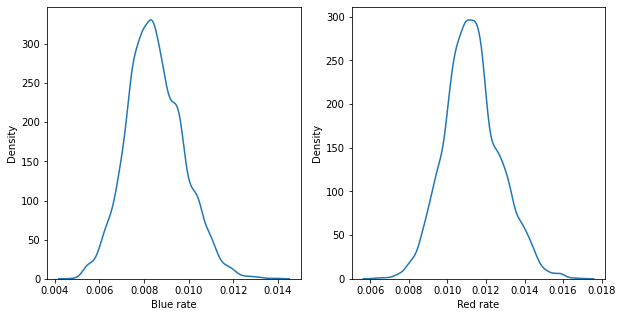

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_xlabel("Blue rate")
ax2.set_xlabel("Red rate")
sns.kdeplot(trace["blue_rate"], ax=ax1)
sns.kdeplot(trace["red_rate"], ax=ax2)

In [84]:
(red_rate_posterior_samples > blue_rate_posterior_samples).mean()

0.9289

**The Bayesian test says that the red button is better than the blue button with a 0.93 "confidence" (probability)**